#Initial look at data
* 188487 records with 4 fields each: category, description, subtitle, title
* Not all records have all four fields: some missing "description" (n=98)
* Two types of "category": plain top-level Kickstarter category like "music" ("coarse" n=15), tagged top-level category like "music/indie rock" ("fine" n=154)
* Records with coarse tag = 41121, 22% of total
* Records with fine tag = 147366, 78% of total
* Some HTML tags in description field: paragraph tag appears ~12k times

In [97]:
import json

with open('kickstarter.json', 'r') as file:
    raw = json.load(file)
    
before = len(raw)    
raw = [i for i in raw if len(i) == 4]
print("Removed", before-len(raw), "records")

temp_counter = 0
for record in raw:
    if record['description'][0:3].lower() == "<p>" and record['description'][-4::].lower() == "</p>":
        temp_counter += 1
        record['description'] = record['description'][3:-4]
print("Removed", temp_counter, "<p></p> tags")

Removed 98 records
Removed 11724 <p></p> tags


#Closer look at existing tags
The records with "coarse" tags make up quite a chunk of the data. Let's look at each top-level category and get a rough idea of the distribution. How many don't have a fine-grain tag?

The horrible pie chart shows that for each top-level category, quite a few have under 50% with more detailed tags (dance, comics, etc).

The Kickstarter corpus here already shows that it might not be very useful for training fine-grained classification, especially for some subject areas - a specific schema, with a lot of manual training, will be better. I won't address that here, though.

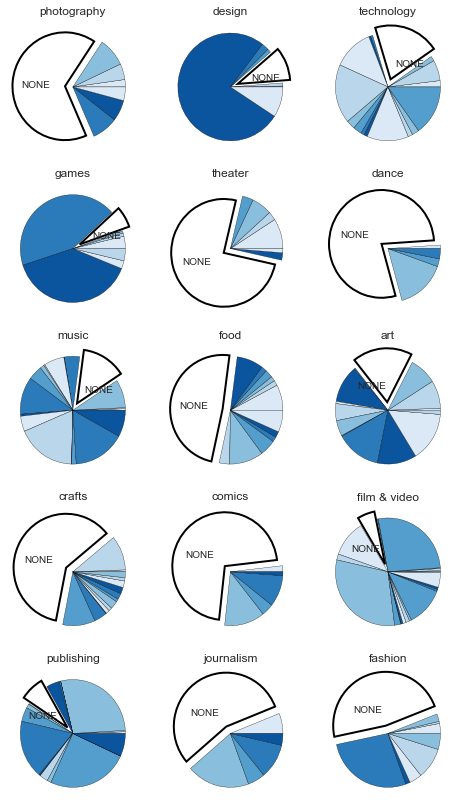

In [98]:
from collections import Counter, defaultdict
import seaborn as sns
%matplotlib inline
pylab.rcParams['figure.figsize'] = 8, 14

categories = Counter([i['category'] for i in raw])

tags = defaultdict(dict)

for k,v in  categories.items():
    if "/" not in k:
        tags[k]["NONE"] = v
    else:
        temp = k.split("/")
        tags[temp[0]][temp[1]] = v
        
tags = dict(tags)

fig = sns.plt.figure()

for i, x in enumerate(tags):
    sp = fig.add_subplot(5, 3, i+1)
    sp.set_title(x)
    labels = [l for l in tags[x].keys()]
    for index, label in enumerate(labels):
        if label != "NONE":
            labels[index] = ""
    explode = [0]*len(tags[x])
    for ind, name in enumerate(tags[x]):
        if name == 'NONE':
            explode[ind] = 0.15
    wedges = sns.plt.pie([v for v in tags[x].values()], labels=labels, explode=explode, labeldistance=0.3, colors=sns.color_palette(name='Blues'))
    for w in wedges[0]:
        if w.get_label() == "NONE":
            w.set_color('#FFFFFF')
            w.set_lw(2)
            w.set_edgecolor('#000000')

#Preparing data for training a classifier
* Main questions:
    1. Which source of data is most informative? Title? Description? Both?
    2. Which kind of tag system is better? Fine or coarse?
* Using only the records that have fine-grained tags, to keep data set sizes equal throughout - I can make "fake" coarse-tag records by stripping down the fine-grained tags.
* Going to run multiple models and cross validate on multiple slices of the data
* Using a 3x2 experimental design: Cartesian product of ([3 x source data types], [2 x tag system])
* Evaluate multiple Naive Bayes methods (Multinomial, Bernoulli) but don't expect major differences
* Evaluate multiple text vectorisers, with fairly unsophisticated tokenisation.
* Use sklearn's Pipeline class to automate a lot of this

In [99]:
from copy import deepcopy

data = deepcopy(raw) #Preserve original-loaded data, otherwise I need to keep reloading it. deepcopy probably not necessary since sub-items are immutable strings

set_aside = [project for project in data if "/" not in project['category']]

set_aside_data = []
for index, t in enumerate(set_aside):
    set_aside_data.append(t['title']+" "+t['description'])

set_aside_labels = [project['category'] for project in set_aside]
    
target_data = [project for project in data if "/" in project['category']]

title_data = [i['title'] for i in target_data]

description_data = [i['description'] for i in target_data]

both_data = []
for index, t in enumerate(title_data):
    both_data.append(t+" "+description_data[index])
    
coarse_labels = [project['category'].split('/')[0] for project in target_data]

fine_labels = [project['category'] for project in target_data]

#Arrange the data and labels for later
Get data ready to be iterated over by Pipelines, automate the cross-validation and get some numbers.

In [100]:
from itertools import product
from collections import namedtuple

data_combinations = []

ModelData = namedtuple('Data_and_Labels', ['config', 'data', 'labels'])

data_combinations.append(ModelData("title data, fine labels", title_data, fine_labels))
data_combinations.append(ModelData("title data, coarse labels", title_data, coarse_labels))
data_combinations.append(ModelData("desc data, fine labels", description_data, fine_labels))
data_combinations.append(ModelData("desc data, coarse labels", description_data, coarse_labels))
data_combinations.append(ModelData("both data, fine labels", both_data, fine_labels))
data_combinations.append(ModelData("both data, coarse labels", both_data, coarse_labels))

#Clean up the data a bit more
Need to remove stopwords. Add "cancelled" and "canceled" to the stopword list, because it appears around 11k times in canceled projects and might get in the way. For example, it might interfere with the games and publishing categories a bit.

In [101]:
import re
from operator import itemgetter

match_cancel = re.compile('cancel')

have_cancel = []
for i in raw:
    if len(re.findall(match_cancel, str(i.values()).lower())) > 0:
        have_cancel.append(i)

print(len(have_cancel), 'records have "cancel*" in them')

canceled_cats = Counter([i['category'] for i in have_cancel])

sorted(canceled_cats.items(), key=itemgetter(1), reverse=True)[0:10]

10645 records have "cancel*" in them


[('games/video games', 974),
 ('film & video/documentary', 838),
 ('design/product design', 713),
 ('film & video/shorts', 678),
 ('games/tabletop games', 633),
 ('publishing/fiction', 485),
 ('film & video/narrative film', 417),
 ('publishing/nonfiction', 370),
 ('film & video/webseries', 339),
 ('music/rock', 283)]

#Set up the vectorisers and classifiers
The per-record text data is fairly sparse and the vocabulary is quite big overall, so it's worth trying different vectorisers. 

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as ESW

ESW = ESW.union({'cancelled', 'canceled'})

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.cross_validation import cross_val_score, KFold

def my_tokeniser(string):
    '''
    This can be changed to result in more sophisticated word detection.
    For now, it just splits up into alpha-only chunks, strips numbers.
    Preserves hyphenated and apostrophed words but ignores other punct.
    Gets rid of single-char stuff.
    '''
    pattern = re.compile("[A-Za-z0-9\-']*[^\W]")
    return [i for i in re.findall(pattern, string) if i.isnumeric() == False and len(i) > 1]

NB_classifiers = [MultinomialNB, BernoulliNB]

vectorisers = [TfidfVectorizer, CountVectorizer]

pipeline_combinations = [i for i in product(vectorisers, NB_classifiers)]

constructed_pipelines = []

for pipe_combo in pipeline_combinations:
    constructed_pipelines.append(Pipeline([
        ('vectoriser', pipe_combo[0](stop_words=ESW, tokenizer=my_tokeniser, ngram_range=(1,1))),
        ('classifier', pipe_combo[1](alpha=0.5))
        ]))

# evaluations = []

# This takes about 5 to 10 minutes, to do 3 evaluations on 24 models
# So I have saved the output to a pickle file to easily reload in notebooks
# 
# for data_combo in data_combinations:
#     for pipe_combo in constructed_pipelines:
#         crossval = KFold(len(data_combo.data), n_folds=3, shuffle=True)
#         results = [data_combo.config,
#                     pipe_combo.get_params()['vectoriser'].__str__().split("(")[0],
#                     pipe_combo.get_params()['classifier'].__str__().split("(")[0],
#                     cross_val_score(pipe_combo, data_combo.data, data_combo.labels, cv=crossval)]                    
#         evaluations.append([results, "Mean cross validation score:", mean(results[3])])

# import pickle

# with open('evaluations.pickle', 'wb') as file:
#     pickle.dump(evaluations, file)

with open('evaluations.pickle', 'rb') as file:
    evaluations = pickle.load(file)

#Get some descriptive stats for the various models
Pandas is nice for this

In [103]:
import pandas as pd
final_data = pd.DataFrame()

for e in evaluations:
    final_data[", ".join(e[0][0:3])] = e[0][3]
    
df1 = final_data.describe()

df1 = df1.T

for col in ['count', 'min', '25%', '50%', '75%', 'max']:
    df1.drop(col, axis=1, inplace=True)

df1.sort('mean',inplace=True, ascending=False)

print(df1)

                                                               mean       std
both data, coarse labels, CountVectorizer, MultinomialNB   0.764993  0.000867
both data, coarse labels, CountVectorizer, BernoulliNB     0.736941  0.002427
both data, coarse labels, TfidfVectorizer, BernoulliNB     0.736622  0.001331
desc data, coarse labels, CountVectorizer, MultinomialNB   0.725405  0.001981
desc data, coarse labels, TfidfVectorizer, BernoulliNB     0.706913  0.001567
desc data, coarse labels, CountVectorizer, BernoulliNB     0.706561  0.000986
both data, coarse labels, TfidfVectorizer, MultinomialNB   0.670494  0.001197
desc data, coarse labels, TfidfVectorizer, MultinomialNB   0.652478  0.001802
title data, coarse labels, CountVectorizer, MultinomialNB  0.612550  0.001611
title data, coarse labels, CountVectorizer, BernoulliNB    0.578159  0.003701
title data, coarse labels, TfidfVectorizer, BernoulliNB    0.577983  0.001775
title data, coarse labels, TfidfVectorizer, MultinomialNB  0.564

#Results so far
* Best vectoriser is (marginally) CountVectoriser, probably because of the vocabulary characteristics.

* Not much difference between classifiers either.

* Using combined title/description as the training data is best, which is not surprising. More data is generally better.

* Using coarse labels is always better than fine labels. This is likely because the source data is too small - even combining description and title, the longest item is 259 chars/35 words. And inflating the number of tags doesn't necessarily increase the resolution of the classifier - it just gives more opportunities to be wrong. Randomly assigning one of 15 tags is likely to have better accuracy than randomly assigning one of 150 tags.

#Refining the model

So, from now on I'll use a CountVectoriser with Multinomial Naive Bayes. The next step is to try different language models by splitting up the source data text into ngrams. I'll continue to use various combinations of labels and so on, though.

In [104]:
NB_classifiers = [MultinomialNB]
vectorisers = [CountVectorizer]

pipeline_combinations = [i for i in product(vectorisers, NB_classifiers)]

ngram_settings = [(1,2), (2,2), (1,3), (3,3)]

constructed_pipelines = []

for pipe_combo in pipeline_combinations:
    for n_setting in ngram_settings:
        constructed_pipelines.append(Pipeline([
            ('vectoriser', pipe_combo[0](stop_words=ESW, tokenizer=my_tokeniser, ngram_range=n_setting)),
            ('classifier', pipe_combo[1](alpha=0.5))
            ]))
# Again, this takes a while to compute so I've pickled the results.
        
# evaluations2 = []

# counter = 0
# for index1, data_combo in enumerate(data_combinations):
#     for index2, pipe_combo in enumerate(constructed_pipelines):
#         counter += 1
#         print('Doing', counter, 'of', len(data_combinations)*len(constructed_pipelines))
#         crossval = KFold(len(data_combo.data), n_folds=3, shuffle=True)
#         results = [data_combo.config,
#                     pipe_combo.get_params()['vectoriser'].ngram_range,
#                     cross_val_score(pipe_combo, data_combo.data, data_combo.labels, cv=crossval)]                    
#         evaluations2.append([results, "Mean cross validation score:", mean(results[2])])

# with open('evaluations2.pickle', 'wb') as file:
#     pickle.dump(evaluations2, file)

with open('evaluations2.pickle', 'rb') as file:
    evaluations2 = pickle.load(file)

df1 = pd.DataFrame()

for e in evaluations2:
    df1[", ".join([str(i) for i in e[0][0:2]])] = e[0][2]

df1_desc = df1.describe()

df1_desc = df1_desc.T

for col in ['count', 'min', '25%', '50%', '75%', 'max']:
    df1_desc.drop(col, axis=1, inplace=True)

df1_desc.sort('mean',inplace=True, ascending=False)

print(df1_desc)

                                       mean       std
both data, coarse labels, (1, 2)   0.751551  0.001642
both data, coarse labels, (1, 3)   0.740381  0.002697
desc data, coarse labels, (1, 2)   0.710408  0.001653
desc data, coarse labels, (1, 3)   0.700019  0.003011
both data, coarse labels, (2, 2)   0.689433  0.000658
desc data, coarse labels, (2, 2)   0.626719  0.003095
title data, coarse labels, (1, 2)  0.610521  0.001446
title data, coarse labels, (1, 3)  0.607074  0.001966
title data, coarse labels, (2, 2)  0.472368  0.002797
both data, coarse labels, (3, 3)   0.462352  0.003980
both data, fine labels, (1, 2)     0.433594  0.001427
both data, fine labels, (1, 3)     0.427935  0.000912
desc data, coarse labels, (3, 3)   0.412904  0.003177
both data, fine labels, (2, 2)     0.410617  0.000596
desc data, fine labels, (1, 2)     0.392173  0.001353
desc data, fine labels, (1, 3)     0.389710  0.002751
desc data, fine labels, (2, 2)     0.348181  0.001406
title data, fine labels, (1,

#Results
Four ngram models were used:

* unigrams and bigrams
* unigrams and bigrams and trigrams
* just bigrams
* just trigrams

Previous results were using just unigrams, with the best model achieving mean accuracy of 0.764993 - outperforming all others.

This is likely due to, again, the type of data. Very short descriptions and titles.

Interestingly, fine labels begin to slightly outperform coarse in some experimental conditions when more than just unigrams are used to represent the text. With additional data to draw on, more sophisticated language models will necessarily capture better relations between lexical items and these should link well to fine-grained tags.

#Predicting tags
Using the best-performing classifier, let's train it on the desc/title data with coarse tags. Then, use it to predict the tag for the set aside data from before.

In [105]:
from sklearn import metrics

best_pipe = Pipeline([
            ('vectoriser', CountVectorizer(stop_words=ESW, tokenizer=my_tokeniser, ngram_range=(1,1))),
            ('classifier', MultinomialNB(alpha=0.5))
            ])

best_pipe.fit(both_data, coarse_labels)

print(best_pipe.score(both_data, coarse_labels))
#This shows how well the model fits overall, using all the data for training.

print(best_pipe.score(set_aside_data, set_aside_labels))
#This shows how it scores on the unseen data, having been trained.

labels_predict = best_pipe.predict(set_aside_data)
#Predict labels for the test data using the trained model

print(metrics.classification_report(set_aside_labels, labels_predict))
#Compare the predicted labels to the known unseen labels

0.857762306095
0.440602125435
             precision    recall  f1-score   support

        art       0.25      0.63      0.35      2756
     comics       0.98      0.06      0.11      3533
     crafts       0.89      0.08      0.14      2301
      dance       0.96      0.01      0.02      2015
     design       0.22      0.48      0.30      1269
    fashion       0.83      0.59      0.69      3725
film & video       0.21      0.81      0.33      2065
       food       0.92      0.85      0.88      4885
      games       0.53      0.73      0.61       975
 journalism       0.31      0.00      0.01      1280
      music       0.64      0.86      0.73      4028
photography       0.95      0.09      0.16      4023
 publishing       0.18      0.67      0.29      1641
 technology       0.66      0.58      0.62      2383
    theater       0.95      0.08      0.14      4242

avg / total       0.72      0.44      0.40     41121



#Results

85% accuracy on the training data is quite good (though not stellar, considering it was trained and tested on the whole data set!) but this falls to 44% on unseen data.

f1-score gives a quick insight into performance: it's variable across the categories, with journalism and dance being especially poor. But given the distribution of categories with regard to available data, this isn't perhaps surprising:

In [106]:
categories = Counter([i['category'].split("/")[0] for i in raw])

cat_sort = sorted(categories.items(), key=itemgetter(1), reverse=True)

for i in cat_sort:
    print(i)

('film & video', 38759)
('music', 29496)
('publishing', 22192)
('games', 15296)
('art', 14999)
('design', 12678)
('technology', 11817)
('food', 10041)
('fashion', 7859)
('photography', 6099)
('theater', 5636)
('comics', 4946)
('crafts', 3776)
('dance', 2575)
('journalism', 2318)


More data generally means better precision/recall. It's not related to the length of the data for each project, since they all have roughly the same number of words each at both the mean and 75% percentile.

In [107]:
import numpy as np

store = defaultdict(list)

for r in raw:
    word_count = len(my_tokeniser(r['title'])) + len(my_tokeniser(r['description']))
    store[r['category'].split("/")[0]].append(word_count)

for k,v in store.items():
    store[k] = [mean(v), np.percentile(v, 75)]

for k,v in store.items():
    print(k,v)

dance [23.751067961165049, 27.0]
design [23.269758637008991, 27.0]
technology [23.691461453837693, 27.0]
games [23.104210251046027, 27.0]
theater [24.146735273243436, 28.0]
photography [22.967043777668469, 27.0]
music [25.033190941144561, 29.0]
food [23.078079872522657, 27.0]
art [23.304486965797722, 27.0]
crafts [22.54343220338983, 27.0]
comics [23.365345733926404, 27.0]
film & video [23.187930545163702, 27.0]
publishing [24.3396268925739, 28.0]
journalism [23.952545297670405, 27.0]
fashion [22.482631378037919, 27.0]


Let's look at the fine-grain labels in the same way. This time, I'll use 78% of the fine labels and combined data to train the classifier, then use the remaining 22% to test prediction ability, followed by an f1-score grid for that.

In [108]:
best_pipe = Pipeline([
            ('vectoriser', CountVectorizer(stop_words=ESW, tokenizer=my_tokeniser, ngram_range=(1,1))),
            ('classifier', MultinomialNB(alpha=0.5))
            ])

best_pipe.fit(both_data, fine_labels)

split_point = int(len(both_data)*0.78)

train_data = both_data[:split_point]
train_label = fine_labels[:split_point]

unseen_data = both_data[split_point:]
unseen_label = fine_labels[split_point:]

print(best_pipe.score(both_data, fine_labels))
#This shows how well the model fits overall, using all the data for training.

print(best_pipe.score(unseen_data, unseen_label))
#This shows how it scores on the unseen data, having been trained.

labels_predict = best_pipe.predict(unseen_data)
#Predict labels for the test data using the trained model

report = metrics.classification_report(unseen_label, labels_predict)
#Compare the predicted labels to the known unseen labels

0.666225587992
0.820394188952


The score on the unseen data overall (88%) is pretty good, but many of the fine-grained categories are not actually used at all - lots of p/r/f1 of 0. Again, though, this is likely due to insufficient training data for those categories.

#Ignoring tags
Instead of trying to assign pre-determined tags, let's try grouping documents according to general similarity. This should get around the data scarcity problem, since all records in the Kickstarter data have, as shown above, roughly the same about of text associated with them. 

In [109]:
from sklearn.cluster import KMeans


pipe = Pipeline([
            ('vectoriser', CountVectorizer(stop_words=ESW, tokenizer=my_tokeniser, ngram_range=(1,1))),
            ('classifier', KMeans(n_clusters=150, n_jobs=-1))
            ])

#pipe.fit(both_data)
#This takes about twenty, so I've pickled the cluster assignments for easy loading.

# with open('kmean_clusters.pickle', 'wb') as file:
#     pickle.dump(pipe.named_steps['classifier'].labels_, file)

with open('kmean_clusters.pickle', 'rb') as file:
    km_clusters = pickle.load(file)

#Visualising k-means
Setting k=150 to broadly mirror the fine-grained categories, the distribution across them is as follows:

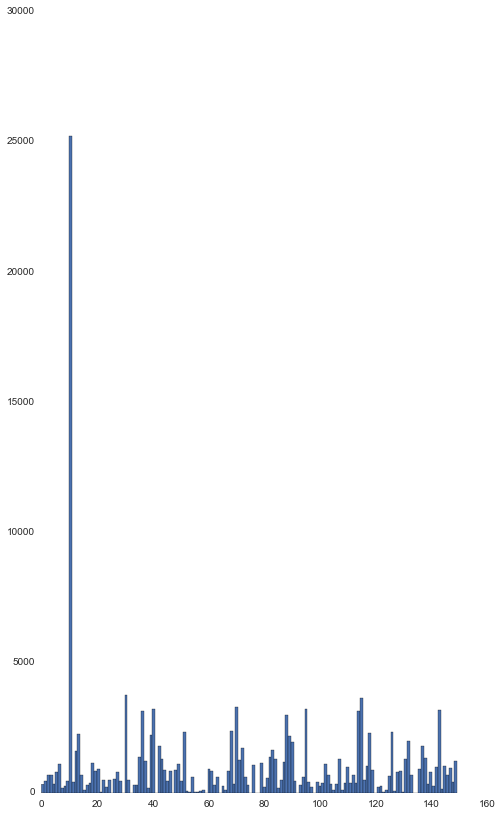

In [110]:
temp = plt.hist(km_clusters, bins=150)

Distributed in a somewhat spiky manner, with one bin especially dominating. Compare this to the distribution based on the fine-tags:

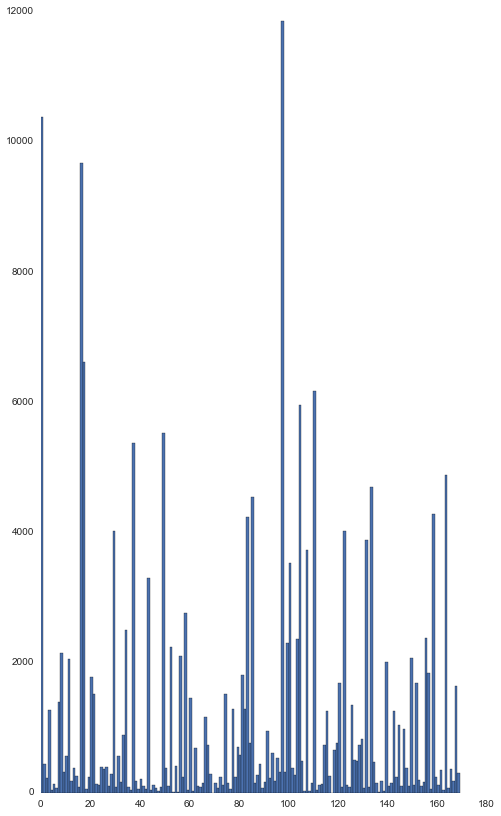

In [111]:
categories = Counter([i['category'] for i in data])

x = list(categories.keys())
y = list(categories.values())
bar1 = plt.bar(range(len(x)), y, 1)

Crude visualisations, but the distributions are quite different - more large groups than assigned to clusters by KMeans. Let's look at some of the assignments and how they map to tags:

In [112]:
results = defaultdict(list)
for triple in zip(km_clusters, both_data, fine_labels):
    results[triple[0]].append([triple[1], triple[2]])

First, look at some of the smaller clusters

In [113]:
r2 = {k:v for k,v in results.items() if len(v) == 100}
for k,v in r2.items():
    print(k,v)

Six of these: one non-English, some have lots of acronyms.

A larger cluster:

In [114]:
len(results[6]) #1121

for i in results[6][0:10]: 
    print(i)

['Beloved Rapture - RPG Game Project Anime-Inspired cinematic adventure! Heavy emphasis on puzzles, exploration and visual storytelling reminiscent of SNES RPGs.', 'games/video games']
["BlindSide: The Audio Adventure Video Game BlindSide is a survival/horror adventure game with no graphics at all. Navigate a 3D world using only your ears and what's between them", 'games/video games']
['" Cuckoo and the Destiny " From our family to yours, "Cuckoo and the Destiny" is a 2D animated experience that will engage your whole family in fun and adventure!', 'film & video/animation']
['Joey and the Ancient Horn, A Mystery Revealed A quick adventure for young readers.\nReading level 9-12 years old', "publishing/children's books"]
['Grey Griffins: Night of Dragons Grey Griffins: Night of Dragons is the next adventure in the Grey Griffins series.', 'publishing/fiction']
['KIT ^N^ KATE — 6 cute episodes for kids & parents Kit ^n^ Kate is a special kind of animated serial for little kids, packed with

These (first ten) show multiple categories, sharing some form of "adventure" in them. Pretty relevant.

#Conclusions
Two constraints on classifier/clusterer success:
    1. The size of the schema used for classification
    2. The source data used to train models

More data is worth the effort, as shown in the early experiments of title vs description vs title+description.

Schema is a bit tricker to deal with - a lot of work has gone into ontologies (I'll discuss in email) but without large enough data to train on, incredibly detailed schemas will end up with a lot of wasted categories simply because the system lacks the resolution to do that kind of fine-grained analysis.

With more data (such as larger descriptions) it would be worthwhile really optimising the tokeniser and general vocabulary generation from the data. For example, making sure that noun phrases are included as single items, preserving capitalisation to a degree, extracting named entities and so on, building up a more detailed semantic representation of the text. At the moment, the language model is just a big bag of words - refining this will results in a more sophisticated representation of the data and allow relations between projects (as exhibited by language) to be determined algorithmically.